In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import texthero as hero

In [2]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_csv('Eluvio_DS_Challenge.csv')

In [5]:
df.head(10)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews
5,1201287889,2008-01-25,15,0,Hay presto! Farmer unveils the illegal mock-...,False,Armagedonovich,worldnews
6,1201289438,2008-01-25,5,0,"Strikes, Protests and Gridlock at the Poland-U...",False,Clythos,worldnews
7,1201536662,2008-01-28,0,0,The U.N. Mismanagement Program,False,Moldavite,worldnews
8,1201558396,2008-01-28,4,0,Nicolas Sarkozy threatens to sue Ryanair,False,Moldavite,worldnews
9,1201635869,2008-01-29,3,0,US plans for missile shields in Polish town me...,False,JoeyRamone63,worldnews


In [6]:
#description of variables stored below for easy access.
#df is main data frame
#dff_topyear (top up votes each year)
#top_15_upvotes (top 15 upvotes over all)
#top_20_over18 (top 20 upvotes in over_18)
#df_processed is dataframe after preprocessed

# Details & Assumptions:
- Dataset: 8 years of data from 2008 to 2016
- up_votes and down_votes are votes from auidence (considered as targets attending events)
- Authors hosting event with respective titles (partially be considered as targets and recommendations can be provided to authors to host based on previous events response)
- Exploratory data analysis
- Data modeling (by clustering based on up_votes and considering over_18)
- Sentiment analysis on title

Note: Above mentioned are basic details, more will be added on drilling down to bottom

In [7]:
df.shape

(509236, 8)

In [8]:
df.dtypes

time_created     int64
date_created    object
up_votes         int64
down_votes       int64
title           object
over_18           bool
author          object
category        object
dtype: object

In [9]:
#first lets check for Null values in dataset given
df.isnull().sum()
#no null vals

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

In [10]:
df.apply(lambda x : len(x.unique()))

time_created    508329
date_created      3223
up_votes          5782
down_votes           1
title           500720
over_18              2
author           85838
category             1
dtype: int64

In [11]:
#1 convert time_created col to below format
df['time_created'] = pd.to_datetime(df['time_created'], unit='s')

In [12]:
df['date_created'] = pd.to_datetime(df['date_created'])

In [13]:
df.dtypes

time_created    datetime64[ns]
date_created    datetime64[ns]
up_votes                 int64
down_votes               int64
title                   object
over_18                   bool
author                  object
category                object
dtype: object

In [14]:
#down_votes col has no other vals than zero's, remove
df['down_votes'].value_counts()

0    509236
Name: down_votes, dtype: int64

In [15]:
#category col has no other strings than worldnews, remove
df['category'].value_counts()

worldnews    509236
Name: category, dtype: int64

In [16]:
df=df.drop(columns=['down_votes','category'])

In [17]:
df=df.set_index('time_created')

In [18]:
df['hour']=df.index.hour
df['day_of_week']=df.index.dayofweek
df['day_of_month']=df.index.day
df['month']=df.index.month

In [19]:
df=df.set_index('date_created')

In [20]:
#Saving file to explore in tableau
#df.to_csv('explore_tableau.csv')

# Exploratory Data Analysis

In [21]:
df.apply(lambda x : len(x.unique()))

up_votes          5782
title           500720
over_18              2
author           85838
hour                24
day_of_week          7
day_of_month        31
month               12
dtype: int64

In [22]:
df.describe()

,up_votes,hour,day_of_week,day_of_month,month
count,509236.000000,509236.000000,509236.000000,509236.000000,509236.000000
mean,112.236283,13.106742,2.716483,15.748618,6.457293
std,541.694675,6.123779,1.917320,8.762333,3.395653
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.000000,9.000000,1.000000,8.000000,3.000000
50%,5.000000,14.000000,3.000000,16.000000,6.000000
75%,16.000000,18.000000,4.000000,23.000000,9.000000
max,21253.000000,23.000000,6.000000,31.000000,12.000000


## Top up_votes in span of 9 years
- Title is on the image below, it is one of the highest up voted with 21253 votes.
- There are no other events having more than 14000 up votes other than the item below.
- Assuming minimum number of auidence is 21253.
- Image source: created on Tableau Public on local machine


<div>
<img src="Image.png" width="600"/>
</div>


In [23]:
# now lets get highest voted event in each year (count #9 but in 2016 2 are highest)
# values in x from tableau on local machine and z ranges from year 2008 to 2016 
x=[1799,3392,3187,4142,7457,10159,9303,21253,13244]
y=[]
yy=[]
for i in x:
    rows=df.loc[df['up_votes'] == i]
    y.append(rows)
    df_topyear = pd.concat(y)
    z=[2008,2009,2010,2011,2012,2013,2014,2015,2016]
    for j in z:
        rows_match=df_topyear.loc[df_topyear.index.year == j]
        yy.append(rows_match)
        dff_topyear = pd.concat(yy)
dff_topyear=dff_topyear.drop_duplicates()
dff_topyear['up_votes']=dff_topyear['up_votes'].drop_duplicates()

In [24]:
dff_topyear=dff_topyear.dropna()

In [25]:
dff_topyear

,up_votes,title,over_18,author,hour,day_of_week,day_of_month,month
date_created,,,,,,,,
2008-10-17,1799.0,The Other Man On The Podium,False,ubikwitous,12,4,17,10
2009-12-22,3392.0,How do I know China wrecked the Copenhagen dea...,False,carsonbiz,22,1,22,12
2016-04-03,13244.0,New report claims war on drugs has harmed p...,False,Owen_Daniel,22,6,3,4
2010-01-12,3187.0,"Dear World, The Chinese government stole intel...",False,frenchphrasebook,23,1,12,1
2011-12-19,4142.0,North Korea Leader Kim-Jong Il has died,False,Merytz,3,0,19,12
2012-11-28,7457.0,"Canada creates $5,000 cap on liability for fil...",False,mepper,17,2,28,11
2013-06-08,10159.0,What we have... is... concrete proof of U.S.-...,False,dantesinfer,1,5,8,6
2014-12-03,9303.0,"NASA officially announces Manned Mars Mission,...",False,Herman999999999,22,2,3,12
2015-06-20,21253.0,A biotech startup has managed to 3-D print fak...,False,KRISHNA53,16,5,20,6


In [26]:
df.shape

(509236, 8)

In [27]:
top_15_upvotes=df.loc[df['up_votes'] >= 10000] #remove .head and run to view all records
top_15_upvotes.head(3)

,up_votes,title,over_18,author,hour,day_of_week,day_of_month,month
date_created,,,,,,,,
2013-06-08,10159,What we have... is... concrete proof of U.S.-...,False,dantesinfer,1,5,8,6
2015-06-20,21253,A biotech startup has managed to 3-D print fak...,False,KRISHNA53,16,5,20,6
2015-08-07,10377,Brazilian radio host famous for exposing corru...,False,fiffers,15,4,7,8


- based on up_votes above are top 15 events and finding the sentiments of above titles may give good insights, will try this in Next parts

In [28]:
df['over_18'].value_counts()

False    508916
True        320
Name: over_18, dtype: int64

In [29]:
top_20_over18=df.loc[df['over_18'] == True]
top_20_over18=top_20_over18.loc[top_20_over18['up_votes']>=1900] #remove .head and run to view all records
top_20_over18.head(3)

,up_votes,title,over_18,author,hour,day_of_week,day_of_month,month
date_created,,,,,,,,
2009-06-20,2547,"Woman killed in protests (Iran) *shocking, nsfw.",True,cactusrex,18,5,20,6
2012-05-17,2351,"Mexico s Drug War: 50,000 Dead in 6 Years",True,mepper,16,3,17,5
2012-09-21,1905,"Muslim, let s get naked : Ukraine-based activ...",True,KatieMorosky,16,4,21,9


- based on up_votes and over_18 (true) above are top 20 events and finding the sentiments of above titles may give good insights, will try this in Next part

In [30]:
top_15_below18=df.loc[df['over_18'] == False]
top_15_below18=top_15_below18.loc[top_15_below18['up_votes']>=10000] #remove .head and run to view all records
top_15_below18.shape

(15, 8)

- based on up_votes and over_18 (false) above are top 15 events and finding the sentiments of above titles may give good insights, will try this in Next part

<AxesSubplot:>

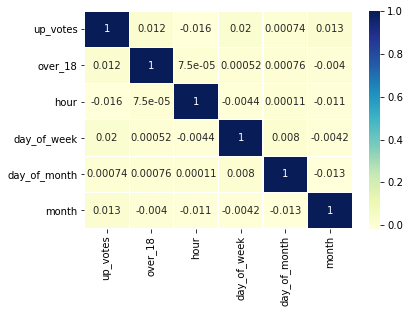

In [31]:
#correlation_matrix
corr_m = df.corr() 
f, ax = plt.subplots(figsize =(6,4)) 
sns.heatmap(corr_m,annot=True, cmap ="YlGnBu", linewidths = 0.1) 

# Preprocessing

In [32]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk import pos_tag
from nltk.corpus import wordnet
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [33]:
from nltk import pos_tag

In [34]:
#variables
stopwords = list(ENGLISH_STOP_WORDS)
#more stopwords can be added by using .append 
p = string.punctuation
d = string.digits
combined = p + d
stop=stopwords.append(combined)
docs1=[]

In [35]:
def func(txt):
    txt = txt.lower() #normalizing
    table = str.maketrans(combined, len(combined) * " ") #removing punc
    txt = txt.translate(table)
    words = txt.split()
    cleaned_words = [w for w in words if w not in stopwords] #removing stopwords
    cleaned_text = " ".join(cleaned_words) #cleaned text
    return cleaned_text

In [36]:
cor1 =(df['title'])
#cor = ','.join([str(i) for i in cor1])
#cor2=func(cor1)
#docs1.append(cor2)

In [37]:
df_trail=df.copy()

In [38]:
df_trail

,up_votes,title,over_18,author,hour,day_of_week,day_of_month,month
date_created,,,,,,,,
2008-01-25,3,Scores killed in Pakistan clashes,False,polar,3,4,25,1
2008-01-25,2,Japan resumes refuelling mission,False,polar,3,4,25,1
2008-01-25,3,US presses Egypt on Gaza border,False,polar,3,4,25,1
2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,3,4,25,1
2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,15,4,25,1
...,...,...,...,...,...,...,...,...
2016-11-22,5,Heil Trump : Donald Trump s alt-right white...,False,nonamenoglory,12,1,22,11
2016-11-22,1,There are people speculating that this could b...,False,SummerRay,12,1,22,11
2016-11-22,1,Professor receives Arab Researchers Award,False,AUSharjah,12,1,22,11


In [39]:
df_trail['title']=df_trail['title'].astype(str)

In [40]:
df_trail['cleaned_title'] = df_trail.title.apply(func)

In [41]:
#lemmatization
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def lem(text):
    lem_doc = []
    out_str=' '
    for i in text.split():
        #pos = pos_tag([i.strip()])
        word = wnl.lemmatize(i.strip())
        lem_doc.append(word)
        out_str=' '.join([str(elem) for elem in lem_doc])
    return lem_doc

In [42]:
df_trail.cleaned_title = df_trail.cleaned_title.apply(lem)

In [43]:
df_trail.head(2)

,up_votes,title,over_18,author,hour,day_of_week,day_of_month,month,cleaned_title
date_created,,,,,,,,,
2008-01-25,3,Scores killed in Pakistan clashes,False,polar,3,4,25,1,"[score, killed, pakistan, clash]"
2008-01-25,2,Japan resumes refuelling mission,False,polar,3,4,25,1,"[japan, resume, refuelling, mission]"


In [44]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [45]:
df_trail['stemmed'] = df_trail['cleaned_title'].map(lambda wl: [stemmer.stem(w) for w in wl])

In [46]:
df_trail['stemd'] = df_trail.stemmed.apply(lambda x: ' '.join([str(i) for i in x]))

In [47]:
df_trail=df_trail.reset_index()
df_trail=df_trail.drop(columns=['date_created','author','hour','day_of_week','day_of_month','month'])

In [48]:
df_trail.to_csv("stem.csv")

In [49]:
#Top words in data
words=pd.Series(np.concatenate(df_trail['stemmed'].values)).value_counts()

In [50]:
words[:10]

s         98825
say       34465
kill      28749
china     25101
new       23332
attack    22538
u         21348
year      20997
syria     18523
russia    18051
dtype: int64

In [51]:
to_plot=words[:30]

<AxesSubplot:>

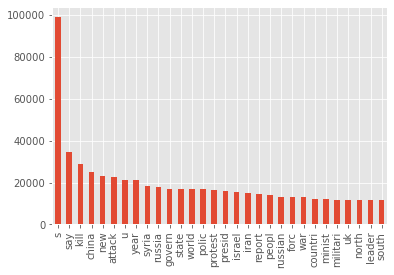

In [52]:
plt.style.use('ggplot')
to_plot.T.plot(kind='bar')

In [53]:
df_trail

,up_votes,title,over_18,cleaned_title,stemmed,stemd
0,3,Scores killed in Pakistan clashes,False,"[score, killed, pakistan, clash]","[score, kill, pakistan, clash]",score kill pakistan clash
1,2,Japan resumes refuelling mission,False,"[japan, resume, refuelling, mission]","[japan, resum, refuel, mission]",japan resum refuel mission
2,3,US presses Egypt on Gaza border,False,"[press, egypt, gaza, border]","[press, egypt, gaza, border]",press egypt gaza border
3,1,Jump-start economy: Give health care to all,False,"[jump, start, economy, health, care]","[jump, start, economi, health, care]",jump start economi health care
4,4,Council of Europe bashes EU&UN terror blacklist,False,"[council, europe, bash, eu, terror, blacklist]","[council, europ, bash, eu, terror, blacklist]",council europ bash eu terror blacklist
...,...,...,...,...,...,...
509231,5,Heil Trump : Donald Trump s alt-right white...,False,"[heil, trump, donald, trump, s, alt, right, wh...","[heil, trump, donald, trump, s, alt, right, wh...",heil trump donald trump s alt right white nati...
509232,1,There are people speculating that this could b...,False,"[people, speculating, madeleine, mccann]","[peopl, specul, madelein, mccann]",peopl specul madelein mccann
509233,1,Professor receives Arab Researchers Award,False,"[professor, receives, arab, researcher, award]","[professor, receiv, arab, research, award]",professor receiv arab research award
509234,1,Nigel Farage attacks response to Trump ambassa...,False,"[nigel, farage, attack, response, trump, ambas...","[nigel, farag, attack, respons, trump, ambassa...",nigel farag attack respons trump ambassador tweet


In [54]:
#dff_topyear (top up votes each year)
#top_15_upvotes (top 15 upvotes over all)
#top_20_over18 (top 20 upvotes in over_18)

In [55]:
dff_topyear.to_csv('dff_topyear.csv')
top_15_upvotes.to_csv('top_15_upvotes.csv')
top_20_over18.to_csv('top_20_over18.csv')
top_15_below18.to_csv('top_15_below18.csv')

In [56]:
sid = SentimentIntensityAnalyzer()

In [57]:
df_trail['scores'] =df_trail['title'].apply(lambda title: sid.polarity_scores(title))
df_trail['compound'] =df_trail['scores'].apply(lambda d:d['compound'])
df_trail['sentiment'] = df_trail['compound'].apply(lambda score: '0' if score>=0 else '1')
df_trail=df_trail.drop(columns=['cleaned_title','stemmed','stemd','scores','compound'])
df_trail['sentiment']=df_trail['sentiment'].astype(int)

In [58]:
def sentimnt(frame):
    frame['scores'] =frame['title'].apply(lambda title: sid.polarity_scores(title))
    frame['compound'] =frame['scores'].apply(lambda d:d['compound'])
    frame['sentiment'] = frame['compound'].apply(lambda score: '0' if score>=0 else '1')
    frame=frame.reset_index()
    frame=frame.drop(columns=['author','hour','day_of_week','day_of_month','month','scores','compound','date_created'])
    frame['sentiment']=frame['sentiment'].astype(int)
    return frame

In [59]:
df_dff_topyear=sentimnt(dff_topyear)
df_top_15_upvotes=sentimnt(top_15_upvotes)
df_top_20_over18=sentimnt(top_20_over18)
df_top_15_below18=sentimnt(top_15_below18)

# Top Insights:

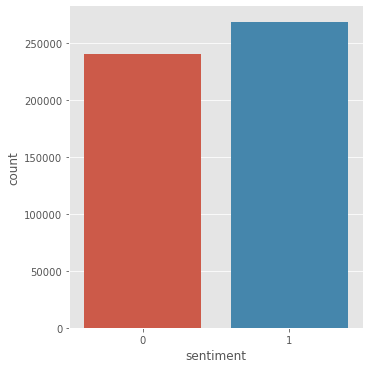

In [60]:
#overall
sns.catplot('sentiment',kind = 'count',data = df_trail,aspect =1)

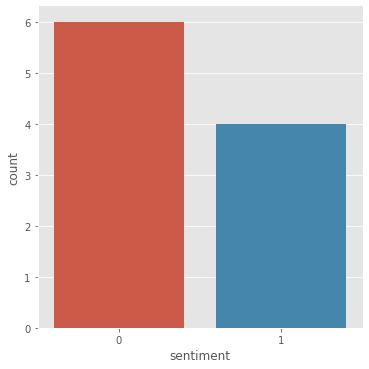

In [61]:
# plot showing upvoted events in each year

sns.catplot('sentiment',kind = 'count',data = df_dff_topyear,aspect =1)

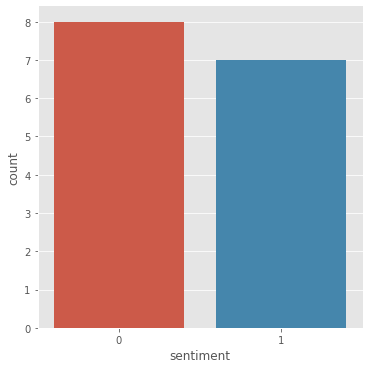

In [62]:
# plot showing top 15 upvoted events

sns.catplot('sentiment',kind = 'count',data = df_top_15_upvotes,aspect =1)

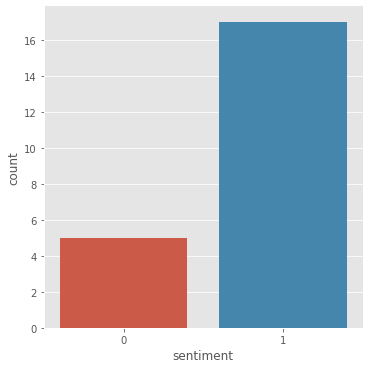

In [63]:
# plot showing top 20 upvoted events with age group over 18

a=sns.catplot('sentiment',kind = 'count',data = df_top_20_over18,aspect =1)

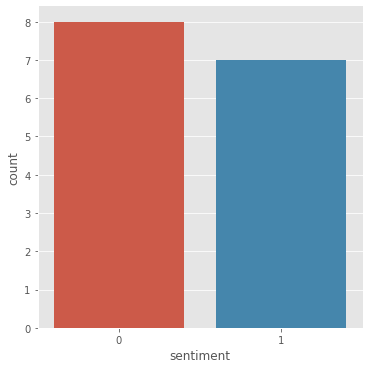

In [64]:
# plot showing top 15 upvoted events with age group below 18

sns.catplot('sentiment',kind = 'count',data = df_top_15_below18,aspect =1)

- Overall auidence:
 - First, majority of auidence on positive sentiment events.  
 - but in top 15 up voted events: negative content events wins with not greater variation to positive events.
- Over 18 vs below 18:
 - Majority of Over18 auidence in top 20 upvoted events are interested in positive content
 - Majority of Below18 auidence in top 15 upvoted events are interested in negative content
- Highest up voted in each year, negative content events had more popularity.

## Continue..
- model building using LSTM is in next notebook